In [74]:
import time
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import torchvision.transforms as transforms
from sklearn.model_selection import KFold

Kept the following code block for reference. We don't use `torch.quantization` - no quantization in general. With quantization, we could go very low in precision (e.g., int8), see [DoReFa](https://arxiv.org/pdf/1606.06160), for example.

Here we want to observe the affect of Gradient on accurasy of precesion types.
We use [Automatic Mixed Precision](https://pytorch.org/docs/stable/amp.html) with Gradeint Norm Clipping. 

For now, we just use the floating-point 16 & 32 with the Global norm clipping, to observe the effect of Gradient on accuracy, taining and testing timings.


In [49]:
print("Supported engines:", torch.backends.quantized.supported_engines)
print("Currently active quantized engine:", torch.backends.quantized.engine)
torch.backends.quantized.engine = "x86"
print("Now active quantized engine:", torch.backends.quantized.engine)

device = "cuda" if torch.cuda.is_available() else "cpu"

Supported engines: ['none', 'onednn', 'x86', 'fbgemm']
Currently active quantized engine: x86
Now active quantized engine: x86


In [70]:
EPOCHS = 3
K_FOLDS = 5
MOMENTUM = 0.9
BATCH_SIZE = 64
LEARNING_RATE = 0.01
CLIP_VALUES = [0.01, 0.1, 0.5, 1.0, 2.0]  # Test 5 different thresholds
MAX_GRAD_NORM = 0.1  # Global norm Gradient clipping threshold

In [51]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Linear layers & ReLU are separate for fusing when quantizing (if someone wants to implement that)
        # MNIST => 28x28=784
        # Linear = fully connected, y=xA^T+b
        # ReLU = activation for non-linearity
        # Output is 10 logits ("logit" = raw output of a linear layer = pre-activation) used later with CrossEntropyLoss
        self.fc1 = nn.Linear(784, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # 28x28 MNIST images are flattened into 784-dim vectors
        x = x.view(x.size(0), -1)  # [batchSize,1,28,28] to [batchSize,784]
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


# Training Function for One Epoch
def trainEpoch(model, train_loader, criterion, optimizer, scaler, max_grad_norm, use_fp16):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass with autocast if FP16
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_fp16):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Backward pass with gradient clipping
        if use_fp16:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(train_loader)

# Evaluation Function
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100.0 * correct / total

In [52]:
# https://stackoverflow.com/questions/63746182/correct-way-of-normalizing-and-scaling-the-mnist-dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
full_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)
test_set = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)


## How does the Gradient affect different precisions type model’s accuracy and performance.

In [ ]:

def kfold_epochs(use_fp16):
    kfold = KFold(n_splits=K_FOLDS, shuffle=True)
    fold_accuracies = []
    fold_train_times = []
    fold_eval_times = []
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset)):
        print(f"\n=== Fold {fold+1}/{K_FOLDS} ({'FP16' if use_fp16 else 'FP32'}) ===")
        # Data loaders
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        
        train_loader = torch.utils.data.DataLoader(
            full_dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(
            full_dataset, batch_size=BATCH_SIZE, sampler=val_subsampler)
        
        # Model setup
        model = MLP().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
        scaler = torch.cuda.amp.GradScaler(enabled=use_fp16)
        # Training loop with timing
        fold_train_start = time.time()
        for epoch in range(EPOCHS):
            train_loss = trainEpoch(model, train_loader, criterion, optimizer, 
                                   scaler, MAX_GRAD_NORM, use_fp16)
            val_acc = evaluate(model, val_loader)
        fold_train_end = time.time()
        
        # Evaluation timing
        fold_eval_start = time.time()
        final_acc = evaluate(model, val_loader)
        fold_eval_end = time.time()
        
        # Store metrics
        fold_accuracies.append(final_acc)
        fold_train_times.append(fold_train_end - fold_train_start)
        fold_eval_times.append(fold_eval_end - fold_eval_start)
    
    return {
        'accuracies': fold_accuracies,
        'train_times': fold_train_times,
        'eval_times': fold_eval_times
    }

fp16_results = kfold_epochs(use_fp16=True)
fp32_results = kfold_epochs(use_fp16=False)



=== Fold 1/5 (FP16) ===


C:\Users\SayedAbozar\AppData\Local\Temp\ipykernel_23004\1844659089.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_fp16)



=== Fold 2/5 (FP16) ===

=== Fold 3/5 (FP16) ===

=== Fold 4/5 (FP16) ===

=== Fold 5/5 (FP16) ===

=== Fold 1/5 (FP32) ===

=== Fold 2/5 (FP32) ===

=== Fold 3/5 (FP32) ===

=== Fold 4/5 (FP32) ===

=== Fold 5/5 (FP32) ===


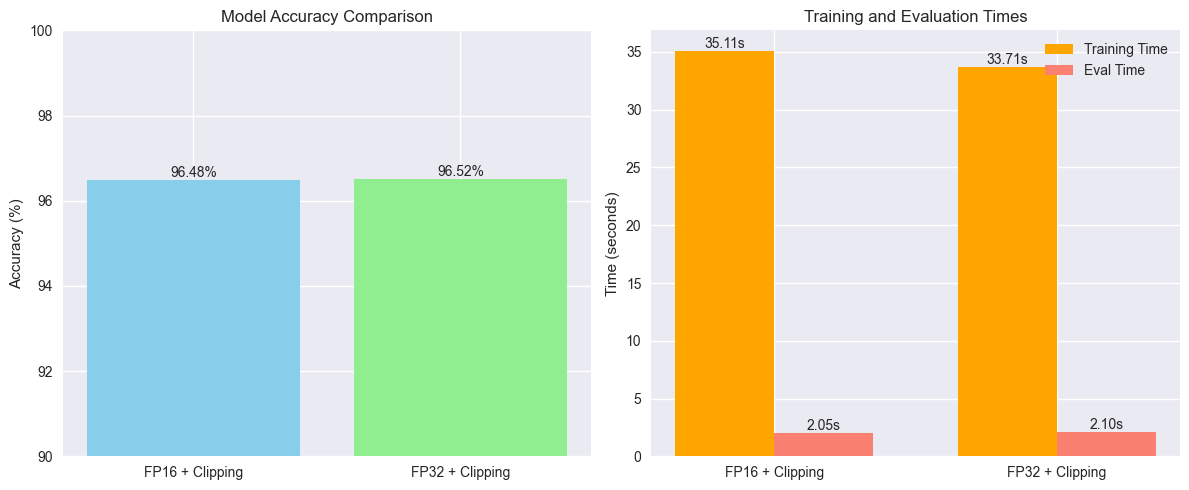


=== Final Results ===
FP16 + Clipping - Accuracy: 96.48% | Train Time: 35.11s | Eval Time: 2.05s
FP32 + Clipping - Accuracy: 96.52% | Train Time: 33.71s | Eval Time: 2.10s


In [ ]:
methods = ['FP16 + Clipping', 'FP32 + Clipping']
accuracies = [
    np.mean(fp16_results['accuracies']),
    np.mean(fp32_results['accuracies'])
]
train_times = [
    np.mean(fp16_results['train_times']),
    np.mean(fp32_results['train_times'])
]
eval_times = [
    np.mean(fp16_results['eval_times']),
    np.mean(fp32_results['eval_times'])
]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bars = plt.bar(methods, accuracies, color=['skyblue', 'lightgreen'])
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim(90, 100)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom')

plt.subplot(1, 2, 2)
bar_width = 0.35
index = np.arange(len(methods))
train_bars = plt.bar(index, train_times, bar_width, label='Training Time', color='orange')
eval_bars = plt.bar(index + bar_width, eval_times, bar_width, label='Eval Time', color='salmon')
plt.ylabel('Time (seconds)')
plt.title('Training and Evaluation Times')
plt.xticks(index + bar_width/2, methods)
plt.legend()

for bars in [train_bars, eval_bars]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}s',
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n=== Final Results ===")
print(f"FP16 + Clipping - Accuracy: {accuracies[0]:.2f}% | Train Time: {train_times[0]:.2f}s | Eval Time: {eval_times[0]:.2f}s")
print(f"FP32 + Clipping - Accuracy: {accuracies[1]:.2f}% | Train Time: {train_times[1]:.2f}s | Eval Time: {eval_times[1]:.2f}s")

## Train the both float-point 16 and float-point 32 Model with different Gradient Value Clipping.

This should show the effect of different Gradients on precision FP16 & Fp32 model during training.

Instead of scaling gradients based on their collective norm, we clips each individual gradient element to a fixed range [-clip_value, clip_value] or we can specify list of few Gradients. This ensures no single gradient component exceeds the specified magnitude.


In [72]:
criterion = nn.CrossEntropyLoss()
def train_with_value_clipping(use_fp16, clip_value):
    """training function for value clipping"""
    kfold = KFold(n_splits=K_FOLDS, shuffle=True)
    fold_accs = []
    fold_train_times = []
    fold_eval_times = []
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset)):
        print(f"\n=== Fold {fold+1}/{K_FOLDS} ({'FP16' if use_fp16 else 'FP32'}) ===")
        # Data loaders
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        
        train_loader = torch.utils.data.DataLoader(
            full_dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(
            full_dataset, batch_size=BATCH_SIZE, sampler=val_subsampler)
        
        # Model setup
        model = MLP().to(device)
        optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
        scaler = torch.cuda.amp.GradScaler(enabled=use_fp16)
        
        # Training
        train_start = time.time()
        for epoch in range(EPOCHS):
            model.train()
            epoch_start = time.time()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()   
                with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_fp16):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                
                if use_fp16:
                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_value_(model.parameters(), clip_value)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    torch.nn.utils.clip_grad_value_(model.parameters(), clip_value)
                    optimizer.step()
            epoch_time = time.time() - epoch_start
        train_time = time.time() - train_start 
        
        # Evaluation
        eval_start = time.time()
        acc = evaluate(model, val_loader)
        eval_time = time.time() - eval_start
        
        fold_accs.append(acc)
        fold_train_times.append(train_time)
        fold_eval_times.append(eval_time)
    
    return {
        'accuracy': np.mean(fold_accs),
        'train_time': np.mean(fold_train_times),
        'eval_time': np.mean(fold_eval_times)
    }

fp16_results = {clip_val: train_with_value_clipping(True, clip_val) for clip_val in CLIP_VALUES}
fp32_results = {clip_val: train_with_value_clipping(False, clip_val) for clip_val in CLIP_VALUES}



=== Fold 1/5 (FP16) ===


C:\Users\SayedAbozar\AppData\Local\Temp\ipykernel_23004\183578229.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_fp16)
c:\Users\SayedAbozar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
c:\Users\SayedAbozar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



=== Fold 2/5 (FP16) ===

=== Fold 3/5 (FP16) ===

=== Fold 4/5 (FP16) ===

=== Fold 5/5 (FP16) ===

=== Fold 1/5 (FP16) ===

=== Fold 2/5 (FP16) ===

=== Fold 3/5 (FP16) ===

=== Fold 4/5 (FP16) ===

=== Fold 5/5 (FP16) ===

=== Fold 1/5 (FP16) ===

=== Fold 2/5 (FP16) ===

=== Fold 3/5 (FP16) ===

=== Fold 4/5 (FP16) ===

=== Fold 5/5 (FP16) ===

=== Fold 1/5 (FP16) ===

=== Fold 2/5 (FP16) ===

=== Fold 3/5 (FP16) ===

=== Fold 4/5 (FP16) ===

=== Fold 5/5 (FP16) ===

=== Fold 1/5 (FP16) ===

=== Fold 2/5 (FP16) ===

=== Fold 3/5 (FP16) ===

=== Fold 4/5 (FP16) ===

=== Fold 5/5 (FP16) ===

=== Fold 1/5 (FP32) ===

=== Fold 2/5 (FP32) ===

=== Fold 3/5 (FP32) ===

=== Fold 4/5 (FP32) ===

=== Fold 5/5 (FP32) ===

=== Fold 1/5 (FP32) ===

=== Fold 2/5 (FP32) ===

=== Fold 3/5 (FP32) ===

=== Fold 4/5 (FP32) ===

=== Fold 5/5 (FP32) ===

=== Fold 1/5 (FP32) ===

=== Fold 2/5 (FP32) ===

=== Fold 3/5 (FP32) ===

=== Fold 4/5 (FP32) ===

=== Fold 5/5 (FP32) ===

=== Fold 1/5 (FP32) ===



=== FP16 Results ===


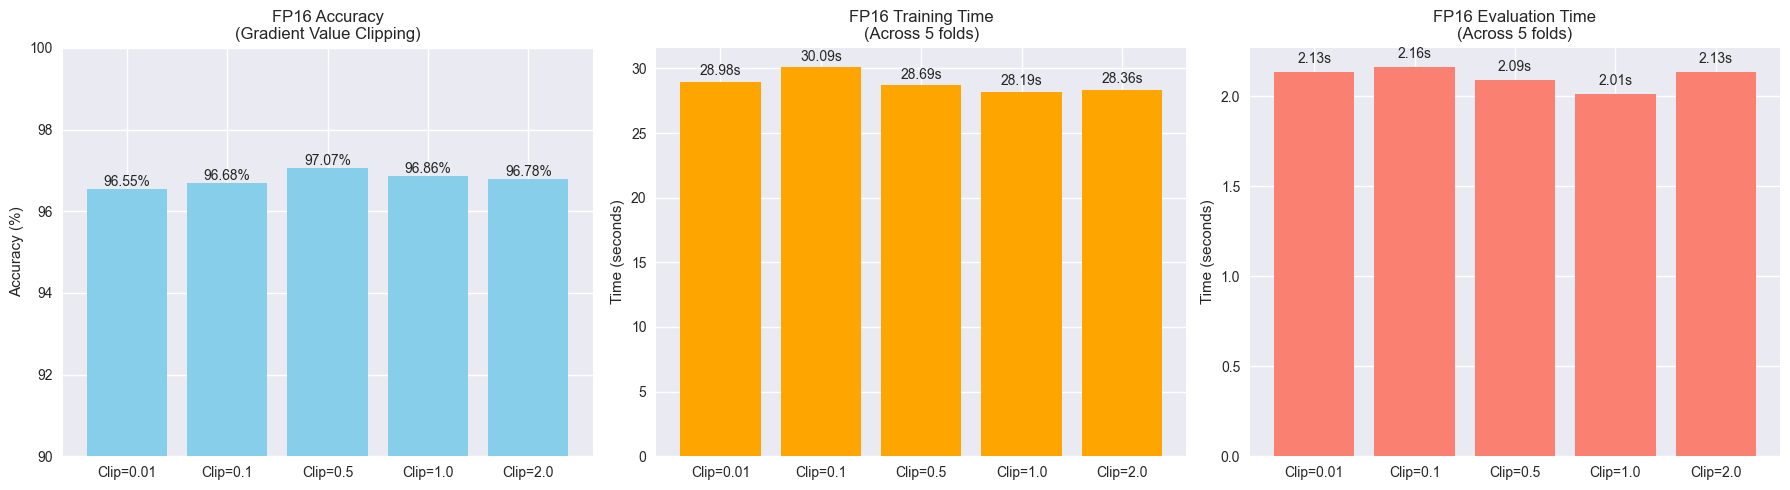


=== FP32 Results ===


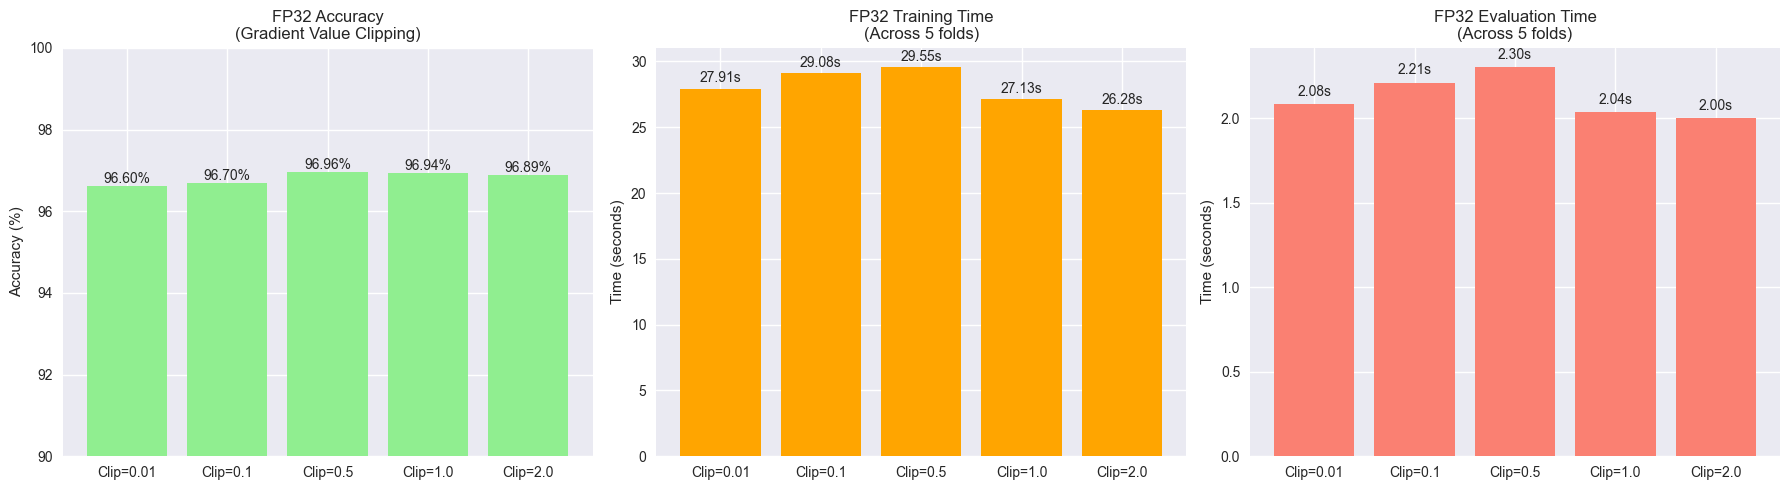


=== FP16 Detailed Results ===
Clip 0.01: Acc=96.55% | Train=28.98s | Eval=2.13s
Clip 0.1: Acc=96.68% | Train=30.09s | Eval=2.16s
Clip 0.5: Acc=97.07% | Train=28.69s | Eval=2.09s
Clip 1.0: Acc=96.86% | Train=28.19s | Eval=2.01s
Clip 2.0: Acc=96.78% | Train=28.36s | Eval=2.13s

=== FP32 Detailed Results ===
Clip 0.01: Acc=96.60% | Train=27.91s | Eval=2.08s
Clip 0.1: Acc=96.70% | Train=29.08s | Eval=2.21s
Clip 0.5: Acc=96.96% | Train=29.55s | Eval=2.30s
Clip 1.0: Acc=96.94% | Train=27.13s | Eval=2.04s
Clip 2.0: Acc=96.89% | Train=26.28s | Eval=2.00s


In [73]:
def plot_results(results, precision):
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    accs = [results[clip_val]['accuracy'] for clip_val in CLIP_VALUES]
    bars = plt.bar(range(len(CLIP_VALUES)), accs, color='skyblue' if precision == 'FP16' else 'lightgreen')
    plt.xticks(range(len(CLIP_VALUES)), [f"Clip={v}" for v in CLIP_VALUES])
    plt.ylabel('Accuracy (%)')
    plt.title(f'{precision} Accuracy\n(Gradient Value Clipping)')
    plt.ylim(90, 100)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:.2f}%', ha='center', va='bottom')
    
    plt.subplot(1, 3, 2)
    train_times = [results[clip_val]['train_time'] for clip_val in CLIP_VALUES]
    plt.bar(range(len(CLIP_VALUES)), train_times, color='orange')
    plt.xticks(range(len(CLIP_VALUES)), [f"Clip={v}" for v in CLIP_VALUES])
    plt.ylabel('Time (seconds)')
    plt.title(f'{precision} Training Time\n(Across {K_FOLDS} folds)')
    for i, t in enumerate(train_times):
        plt.text(i, t + 0.5, f'{t:.2f}s', ha='center')

    plt.subplot(1, 3, 3)
    eval_times = [results[clip_val]['eval_time'] for clip_val in CLIP_VALUES]
    plt.bar(range(len(CLIP_VALUES)), eval_times, color='salmon')
    plt.xticks(range(len(CLIP_VALUES)), [f"Clip={v}" for v in CLIP_VALUES])
    plt.ylabel('Time (seconds)')
    plt.title(f'{precision} Evaluation Time\n(Across {K_FOLDS} folds)')
    for i, t in enumerate(eval_times):
        plt.text(i, t + 0.05, f'{t:.2f}s', ha='center')
    
    plt.tight_layout()
    plt.show()

print("\n=== FP16 Results ===")
plot_results(fp16_results, 'FP16')

print("\n=== FP32 Results ===")
plot_results(fp32_results, 'FP32')

print("\n=== FP16 Detailed Results ===")
for clip_val in CLIP_VALUES:
    res = fp16_results[clip_val]
    print(f"Clip {clip_val}: Acc={res['accuracy']:.2f}% | Train={res['train_time']:.2f}s | Eval={res['eval_time']:.2f}s")

print("\n=== FP32 Detailed Results ===")
for clip_val in CLIP_VALUES:
    res = fp32_results[clip_val]
    print(f"Clip {clip_val}: Acc={res['accuracy']:.2f}% | Train={res['train_time']:.2f}s | Eval={res['eval_time']:.2f}s")